<a href="https://colab.research.google.com/github/Stray-Weights/Dlthon_01_Motocycle_Night_Ride/blob/main/aa-in/model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 모델 구현 (이아인)
**사전준비**  
내 구글 드라이브의 데이터 가져오기 **(다른 분들은 이 과정 생략하세요)**

In [ ]:
# 구글 드라이브 마운트 & 소스파일 가져오기
from google.colab import drive
from IPython.display import clear_output, HTML, display
import ipywidgets as widgets
import os

drive.mount('/content/drive')
clear_output()

WEEK = 'week7/dltone/dataset'
mypath = os.path.join('/content/drive/MyDrive/Aiffel', WEEK)

def info_msg(msg, style=1, width='450px'):
    # color = '#2ecc71' if style == 1 else '#e67e22'
    color = '#3498db' if style == 1 else '#e67e22'
    mark = '\u2714' if style == 1 else '\u26A0 Warning: '

    html_code = f"""
    <div style="
        background-color: {color};
        color: white;
        padding: 20px 20px;
        border-radius: 15px;
        width: {width};
        text-align: center;
        font-family: 'Malgun Gothic', sans-serif;
        font-weight: bold;
        font-size: 16px;

        margin: 12px 0;
    ">
        {mark} {msg}
    </div>
    """
    display(HTML(html_code))

print(mypath)
info_msg('Google Drive has mounted.', 1)

# 임시 폴더 생성
!mkdir -p "source/images"
!mkdir -p "source/models"

# 구글 드라이브에서 데이터셋 복사해오기
!cp -r "$mypath/." "/content/source"

# 복사된 폴더 내의 파일 개수 확인
qty = !find /content/source/images -type f | wc -l

# 정답파일 불러오기
json_path = '/content/source/COCO_motorcycle (pixel).json'

info_msg(f'{int(qty[0])}개의 이미지들을 성공적으로 가져왔습니다.', 1)

/content/drive/MyDrive/Aiffel/week7/dltone/dataset


---

##준비
1. 모델학습을 구글 코랩에서 하기 위한 준비
2. 필요 라이브러리
3. 데이터 준비
4. 샘플 이미지 준비
---
### 1. 모델학습을 구글 코랩에서 하기 위한 준비

In [27]:
# 모델학습을 구글 코랩에서 하기 위한 준비
%cd /content/drive/MyDrive/Aiffel/week7/dltone/data
!pwd

/content/drive/MyDrive/Aiffel/week7/dltone/data
/content/drive/MyDrive/Aiffel/week7/dltone/data


### 2. 필요 라이브러리

In [ ]:
! pip install opencv-python
clear_output()

In [26]:
from dotenv import load_dotenv
from pathlib import Path
import cv2
import os, json
import numpy as np
import torch
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt

# Device 설정 - 코랩의 GPU 사용 여부 체크
# [런타임] - [런타임 유형 변경]에서 T4 GPU 선택 권장
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

info_msg(f"현재 사용 중인 장치: {device}", 1)

---
# 여기서부터 데이터 전처리 코드(김종하 님)

### 3. 데이터 준비

In [29]:
# 데이터 준비
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""

    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name

    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

def run():
    """앞으로 작업할 모든 작업에서 쓰는 경로 반환 함수"""
    path_manager = PathManager()

    # 기본 경로, 이미지 폴더 경로, 데이터 폴더 경로
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    data_dir = path_manager._datas_dir

    # 이미지 폴더 내의 이미지 경로
    my_image_path = path_manager.get_image_path("night ride (7).png")

    # 원본
    my_image_origin = cv2.imread(my_image_path)

    # 원본을 rgb로 변환 후 변수 저장
    my_image_rgb = cv2.cvtColor(my_image_origin, cv2.COLOR_BGR2RGB)

    # json 경로
    my_json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")

    # json 로드
    with open (my_json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    return root_path, images_dir, data_dir, my_json_origin

# root_path: .env 파일의 부모 폴더, images_dir: 이미지 폴더 주소, data_dir: 데이터 폴더 주소, my_json_origin: json파일 객체
root_path, images_dir, data_dir, my_json_origin = run()

폴더에 있는 이미지 파일 가져오기

In [30]:
# 1. 이미지 폴더 내의 모든 파일 리스트업
# PathManager의 속성을 활용합니다.
all_files = os.listdir(images_dir)

# 2. 이미지 확장자만 필터링 (순서가 달라도 상관없습니다, 이름으로 매칭할 거니까요)
valid_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in all_files if f.lower().endswith(valid_extensions)]

print(f"찾은 이미지 개수: {len(image_files)}장") # 여기서 200이 나와야 합니다.

찾은 이미지 개수: 600장


폴더에 있는 이미지 파일 중 save랑 fuse 제외하고 가져오기

In [31]:
# 1. 'save'와 'fuse'가 이름에 들어간 파일은 제외하고 순수 'night ride'와 'Screenshot'만 추출
# 리스트 컴프리헨션을 사용하여 조건부 필터링을 수행합니다.
image_files = [
    f for f in all_files
    if f.lower().endswith(valid_extensions)
    and 'save' not in f.lower()
    and 'fuse' not in f.lower()
]

print(f"정제된 이미지 개수: {len(image_files)}장")
# 여기서 정확히 200장이 나오는지 확인하십시오.

print(image_files[99])

정제된 이미지 개수: 200장
night ride (81).png


JSON과 입력파일이 실제로 매칭하는지 확인해서 매칭된것만 가져오기

In [32]:
# JSON에 등록된 모든 파일 이름을 집합(Set)으로 만듭니다. (검색 속도 최적화)
json_filenames = {img['file_name'] for img in my_json_origin['images']}

# 폴더에는 있지만 JSON에는 없는 유령 파일들을 걸러냅니다.
final_image_files = [f for f in image_files if f in json_filenames]

print(f"최종 매칭된 이미지 개수: {len(final_image_files)}장")

최종 매칭된 이미지 개수: 200장


In [33]:
from sklearn.model_selection import train_test_split

# 0. 팀원들끼리 공유할떄 시드값이 고정되어도 기본 파일정렬은 os마다 다를 수 있습니다. 그래서 추가했습니다.
final_image_files = sorted(final_image_files)

# 1. 전체 200장에서 먼저 Test 20장(10%)을 분리합니다.
# 200 * 0.1 = 20
train_val_files, test_files = train_test_split(
    final_image_files,
    test_size=0.1,
    random_state=2026
)

# 2. 남은 180장에서 다시 Val 20장(약 11.1%)을 분리합니다.
# 180 * (20/180) = 20
train_files, val_files = train_test_split(
    train_val_files,
    test_size=20/180,
    random_state=2026
)

print(f"✅ 분리 완료 (Seed: 2026)")
print(f"훈련 데이터(Train): {len(train_files)}장")
print(f"검증 데이터(Val): {len(val_files)}장")
print(f"테스트 데이터(Test): {len(test_files)}장")

✅ 분리 완료 (Seed: 2026)
훈련 데이터(Train): 160장
검증 데이터(Val): 20장
테스트 데이터(Test): 20장


데이터셋 정의

In [34]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map

        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            A.Resize(528, 528, interpolation=cv2.INTER_LINEAR),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]

        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        transformed = self.mask_resize(image=image, mask=full_mask)
        transformed = self.transform(image=transformed['image'], mask=transformed['mask'])

        return transformed['image'], transformed['mask'].long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)

        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask

        image_id = image_info['id']

        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]

        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}

        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)

            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)
        return mask

내가 설정한 클래스맵과 json 내부의 클래스명 일치여부 확인

In [35]:
def check_categories(json_data):
    """위에서 정의한 CLASS_MAP객체의 키들이 JSON의 카테고리와 철자가 정확하게 맞는지 확인인"""
    # JSON 내부에 실제 등록된 카테고리 이름들 추출
    json_cat_names = [cat['name'] for cat in json_data.get('categories', [])]
    print(f"JSON 내 카테고리: {json_cat_names}")

    # 위에서 정의한 CLASS_MAP과 비교
    for name in CLASS_MAP.keys():
        if name not in json_cat_names:
            print(f"⚠️ 경고: '{name}' 클래스가 JSON에 존재하지 않습니다. 철자를 확인하세요.")
        else:
            print(f"✅ 확인: '{name}' 매칭 완료.")

# 실행
check_categories(my_json_origin)

JSON 내 카테고리: ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
✅ 확인: 'Undrivable' 매칭 완료.
✅ 확인: 'Road' 매칭 완료.
✅ 확인: 'Lane Mark' 매칭 완료.
✅ 확인: 'My bike' 매칭 완료.
✅ 확인: 'Rider' 매칭 완료.
✅ 확인: 'Moveable' 매칭 완료.


데이터 로더 정의 (데이터셋을 제공하는 함수, loader 들을 반환)

In [37]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])

    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader

# 실행 예시
train_loader, val_loader, test_loader = get_loaders(images_dir, my_json_origin, CLASS_MAP)

200


In [38]:
# 첫 번째 배치 규격 확인
images, masks = next(iter(train_loader))

print(f"이미지 배치 크기: {images.shape}") # [4, 3, 528, 528] (Batch, Channel, H, W)
print(f"마스크 배치 크기: {masks.shape}") # [4, 528, 528] (Batch, H, W)
print(f"마스크 내 고유 값: {torch.unique(masks)}") # [0, 1, 2, 3, 4, 5] (사전에 정한 클래스 번호)

이미지 배치 크기: torch.Size([4, 3, 528, 528])
마스크 배치 크기: torch.Size([4, 528, 528])
마스크 내 고유 값: tensor([0, 1, 2, 3, 4, 5])


---
# 여기서부터 모델 구현(이아인)

### 4. 샘플용 이미지 한장 준비

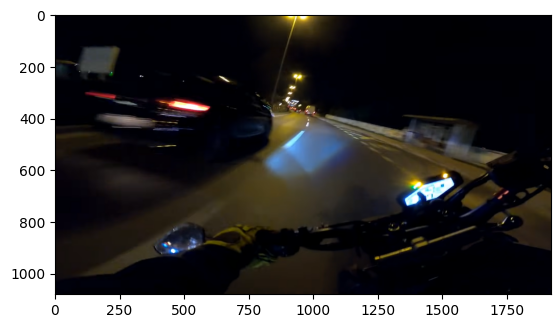

In [ ]:
# 샘플용으로 이미지 한장 확인
img1 = cv2.imread("/content/source/images/Screenshot (309).png")
img1_RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_RGB)
plt.show()

## 1.1 [실험1] DeepLabv3+ 아키텍처
DeepLabv3+ with ResNet-50 Backbone
### 1.1.1 모델 준비

- `eval()`은 모델을 '평가(추론)' 모드로 바꿈. 학습을 위해서는 `.train()` 사용

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

# 1. ResNet50 기반 DeepLabv3 로드 (사전 학습 가중치 포함)
#    weights='DEFAULT'는 pretrained=True와 동일함.
model = deeplabv3_resnet50(weights='DEFAULT')

# 2. 출력 클래스 수정 (6개 클래스)
NUM_CLASSES = 6

# 메인 분류기 수정
in_channels = model.classifier[4].in_channels
model.classifier[4] = torch.nn.Conv2d(
    in_channels, NUM_CLASSES, kernel_size=(1, 1)
)

# 보조 분류기 수정
in_channels_aux = model.aux_classifier[4].in_channels
model.aux_classifier[4] = torch.nn.Conv2d(
    in_channels_aux, NUM_CLASSES, kernel_size=(1, 1)
)

model.to(device)
print("="*30)
print("ResNet50 백본 기반 DeepLabv3 설정 완료")
print(f"최종 출력 채널: {model.classifier[4].out_channels}")
print("="*30)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 186MB/s]


ResNet50 백본 기반 DeepLabv3 설정 완료
최종 출력 채널: 6


### 1.1.2 Baseline Visualization
- 학습 전 모델이 해석한 이미지 결과값

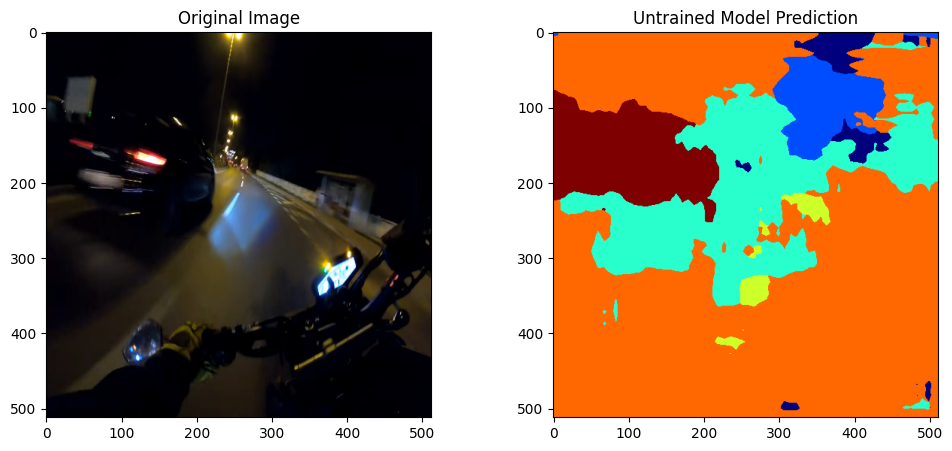

In [ ]:
# 1. 테스트용 더미 이미지 또는 실제 이미지 한 장 준비

# 전처리 파이프라인 (전처리 팀의 규격과 동일하게 설정할 예정)
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img1_RGB).unsqueeze(0).to(device)

# 2. 모델을 평가 모드로 설정하고 추론 (학습 전 상태)
model.to(device) # 모델을 GPU로 이동
model.eval()

with torch.no_grad():
    # DeepLabv3의 출력은 딕셔너리 형태
    output = model(input_tensor)['out'] # 결과: (1, 6, 512, 512)
    # 6개 채널 중 가장 확률이 높은 클래스 인덱스만 추출
    # dim=1 (클래스 차원)에서 최대값을 찾고, squeeze(0)로 배치 차원 제거
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# 3. 결과 시각화
plt.figure(figsize=(12, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(img1_RGB, (512, 512), interpolation=cv2.INTER_LINEAR))

plt.title("Original Image")

# 모델의 예측 결과 (Color map 적용)
plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap='jet')
plt.title("Untrained Model Prediction")

plt.show()

### 1.1.3 손실함수 및 최적화 설정
손실함수  
- Dice Loss: 클래스 불균형 해결
  - 야간 주행 영상에서 '차선(Lanemark)'은 전체 픽셀의 1%도 안 될 수 있음.
  픽셀 개별의 정답 여부만 따지는 CrossEntropy의 한계를 극복하기 위해, 예측 영역과 실제 영역의 교집합을 극대화하는 Dice Loss는 작은 객체도 놓치지 않게 만듦.

- Cross Entropy Loss:
  - 모든 픽셀에 대해 개별적으로 정답 여부를 판별
  - CrossEntropy만 쓰면 모델은 차선을 틀려도 전체 점수에 영향이 적다고 판단해 차선을 포기해버림.

옵티마이저  
- AdamW:
  - Adam에 가중치 감쇠(Weight Decay)를 개선한 알고리즘. 과적합 방지에 탁월.
  - 적은 데이터(200장)에서 모델이 노이즈까지 외워버리는 현상을 수학적으로 억제하여 모델의 성능을 일반화 해줌.

In [ ]:
# 1. Dice Loss 정의 (클래스 불균형 해결사)
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predict, target):
        # predict: (Batch, 6, H, W), target: (Batch, H, W)
        predict = torch.softmax(predict, dim=1)

        # 정답(target)을 One-hot 인코딩으로 변환 (Batch, 6, H, W)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=6).permute(0, 3, 1, 2).float()

        intersection = (predict * target_one_hot).sum(dim=(0, 2, 3))
        union = predict.sum(dim=(0, 2, 3)) + target_one_hot.sum(dim=(0, 2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# 2. 손실함수 선언
criterion_ce = torch.nn.CrossEntropyLoss()
criterion_dice = DiceLoss()

# 3. 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# 학습률 스케줄러: 학습이 진행됨에 따라 학습률을 조금씩 낮춰 정교하게 수렴하도록 함.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### 1.1.4 Dry Run
진짜 데이터와 똑같은 모양을 가진 가짜 데이터로 학습 루프가 잘 돌아가는 테스트 하는 과정  
- 목적
  - 코드게 에러 없이 끝까지 돌아가는가?  
    손실함수, 역전파와 최적화가 에러없이 잘 맞물려 돌아가는지 확인
  - 현재 설정한 배치 사이트가 코랩의 GPU메모리를 초과하지 않는지 확인
- 사용 데이터
  무작위 노이즈의 더미 데이터

In [ ]:
from torch.utils.data import Dataset, DataLoader

# 1. 가짜 데이터셋 클래스 정의 (전처리 팀이 올 때까지 임시로 사용)
class DummyDataset(Dataset):
    def __init__(self, num_samples=10, img_size=(512, 512)):
        self.num_samples = num_samples
        self.img_size = img_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 실제 이미지와 똑같은 형태의 랜덤 텐서 생성 (3, 512, 512)
        image = torch.randn(3, *self.img_size)
        # 실제 마스크와 똑같은 형태의 랜덤 정수 텐서 생성 (0~5 사이의 값, 512, 512)
        mask = torch.randint(0, 6, self.img_size).long()
        return image, mask

# 2. 데이터 로더 생성 (임시)
dummy_ds = DummyDataset(num_samples=20) # 20장만 생성
train_loader = DataLoader(dummy_ds, batch_size=4, shuffle=True)

print(train_loader)
print("✅ 전처리 팀 대신 가짜 데이터로더(train_loader)가 준비되었습니다.")

✅ 전처리 팀 대신 가짜 데이터로더(train_loader)가 준비되었습니다.


랜덤하게 생성된 이미지라 학습이 되지 않음.  
가중치가 거의 변하지 않는 것을 볼 수 있다.

In [ ]:
# AdamW와 Dice + CE 복합 손실 함수를 사용
def train_one_epoch(model, dataloader, optimizer, criterion_ce, criterion_dice, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device) # (Batch, H, W)

        optimizer.zero_grad() # 그래디언트 초기화

        # 1. Forward Pass
        outputs = model(images)['out'] # (Batch, 6, H, W)

        # 2. Loss 계산
        loss_ce = criterion_ce(outputs, masks)
        loss_dice = criterion_dice(outputs, masks)

        # 3. Backward Pass & Optimize
        # 3-1. (Dice 단독 손실)
        loss_dice.backward()

        # 3-2. (CE + Dice 복합 손실)
        loss_combined = (0.5 * loss_ce) + (0.5 * loss_dice) # 1:1 비율로 혼합
        # loss_combined.backward()

        # 4. Optimize
        optimizer.step()

        running_loss += loss_dice.item()

    return running_loss / len(dataloader)

# --- 실제 학습 실행부 ---
# 데이터가 200장이므로 에폭을 충분히 가져가되 과적합 주의
num_epochs = 30
best_loss = float('inf')

for epoch in range(num_epochs):
    # 훈련 세트로 학습
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion_ce, criterion_dice, device)

    # [검증 파트 - 기능 구현 팀에게 요청할 부분]
    # val_loss = validate(model, val_loader, criterion_ce, criterion_dice, device)

    scheduler.step() # 학습률 조정

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}")

    # 최적 모델 저장 (Early Stopping 대용)
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), 'best_model_resnet50.pth')
        print("Model Saved!")

Epoch [1/30] - Loss: 0.8335
Model Saved!
Epoch [2/30] - Loss: 0.8334
Model Saved!
Epoch [3/30] - Loss: 0.8333
Model Saved!
Epoch [4/30] - Loss: 0.8333
Epoch [5/30] - Loss: 0.8333
Epoch [6/30] - Loss: 0.8334
Epoch [7/30] - Loss: 0.8333
Epoch [8/30] - Loss: 0.8334
Epoch [9/30] - Loss: 0.8333
Epoch [10/30] - Loss: 0.8333
Model Saved!
Epoch [11/30] - Loss: 0.8333
Epoch [12/30] - Loss: 0.8334
Epoch [13/30] - Loss: 0.8333
Epoch [14/30] - Loss: 0.8333
Model Saved!
Epoch [15/30] - Loss: 0.8333
Epoch [16/30] - Loss: 0.8334
Epoch [17/30] - Loss: 0.8334
Epoch [18/30] - Loss: 0.8333
Epoch [19/30] - Loss: 0.8334
Epoch [20/30] - Loss: 0.8333
Epoch [21/30] - Loss: 0.8334
Epoch [22/30] - Loss: 0.8333
Epoch [23/30] - Loss: 0.8333
Epoch [24/30] - Loss: 0.8333
Epoch [25/30] - Loss: 0.8334
Epoch [26/30] - Loss: 0.8333
Epoch [27/30] - Loss: 0.8333
Epoch [28/30] - Loss: 0.8333
Epoch [29/30] - Loss: 0.8333
Epoch [30/30] - Loss: 0.8334


### 1.1.5 새니티 체크(Sanity Check)
- 목적: 모델이 제정신인지 체크하는 과정  
- 데이터: 실제 이미지 한장
- 성공기준: Loss가 0에 가깝게 수렴하는지
---
DeepLabv3+ 내부에는 데이터들의 평균(\mu)과 분산(\sigma^2)을 계산해서 숫자를 정규화하는 Batch Normalization(BN) 층이 아주 많다.
우리는 Batch Size = 1 (이미지 딱 한 장)로 학습(model.train()) 하기 때문에 데이터가 딱 하나뿐이라 분산을 계산할 수 없다. 수학적으로 분산을 구하려면 최소 2개 이상의 데이터가 필요하다.

 해결책: BatchNorm만 '평가 모드'로 속이기
 모델 전체는 train() 모드로 두되, Batch Normalization 층들만 eval() 모드로 고정한다.   이렇게 하면 모델은 학습을 계속하면서도, BN 층은 미리 학습된(ImageNet) 통계치를 사용하여 에러를 내지 않는다.

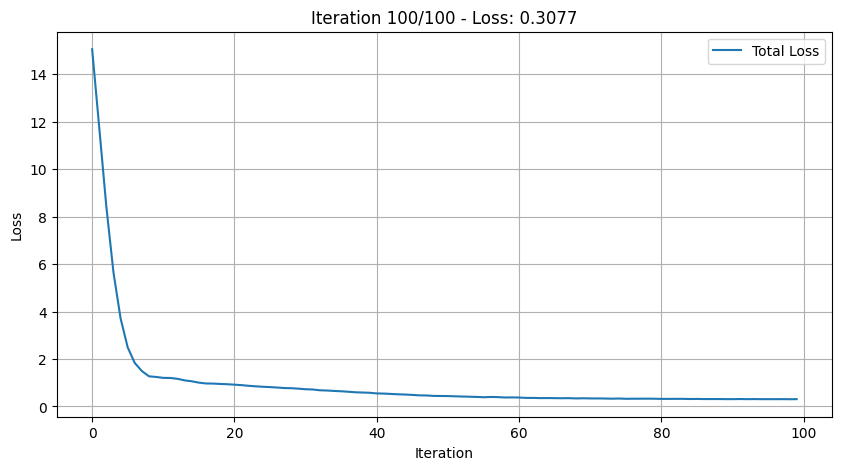

✅ 학습 완료! 모델이 정답을 완벽히 외웠습니다.


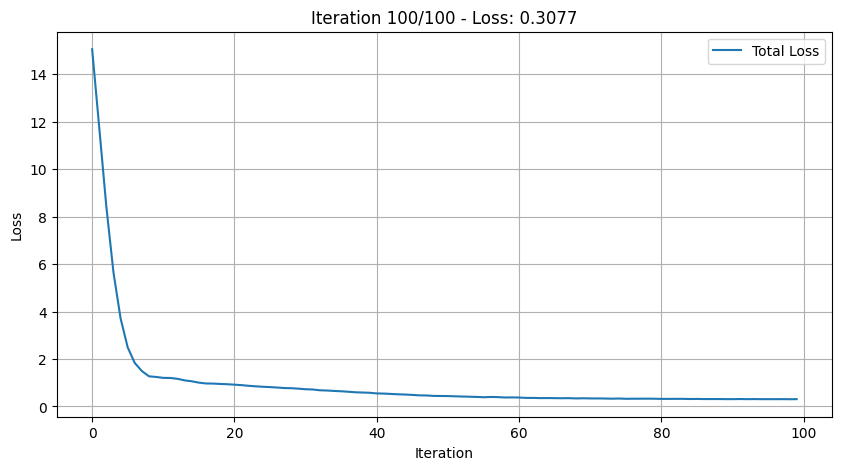

In [ ]:
# 1. COCO JSON에서 img1_RGB의 정답(Annotation) 찾아 마스크 만들기
def get_target_mask_from_json(json_path, target_file_name, img_size=(512, 512)):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # 해당 파일명의 이미지 ID 찾기
    img_id = None
    for img in data['images']:
        if img['file_name'] == target_file_name:
            img_id = img['id']
            orig_h, orig_w = img['height'], img['width']
            break

    if img_id is None:
        print(f"❌ {target_file_name}을 JSON에서 찾을 수 없습니다.")
        return None

    # 클래스 맵핑 (우리 프로젝트 규격)
    class_map = {'background': 0, 'road': 1, 'lane': 2, 'rider': 3, 'bike': 4, 'movable': 5}
    cat_id_to_name = {cat['id']: cat['name'].lower() for cat in data['categories']}

    # 빈 마스크 생성 (원본 크기)
    mask = np.zeros((orig_h, orig_w), dtype=np.uint8)

    # 좌표(Polygon) 그리기
    for ann in data['annotations']:
        if ann['image_id'] == img_id:
            cat_name = cat_id_to_name[ann['category_id']]
            class_idx = class_map.get(cat_name, 0)
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [poly], class_idx)

    # 모델 입력 크기(512x512)로 리사이즈 (반드시 NEAREST 사용)
    mask_resized = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    return torch.from_numpy(mask_resized).long().to(device).unsqueeze(0) # (1, 512, 512)

# 모델 전체는 train() 모드로 두되, Batch Normalization 층들만 eval() 모드로 고정
def set_train_mode(model):
    model.train() # 전체 모델은 학습 모드
    for m in model.modules():
        if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
            m.eval() # BatchNorm 층만 평가 모드로 고정 (분산 계산 방지)
            m.weight.requires_grad = False # 가중치 업데이트 중단 (선택 사항)
            m.bias.requires_grad = False

# --- 실행 파트 ---
# 실험용 이미지 한장
target_file_name = 'Screenshot (309).png'

target_mask = get_target_mask_from_json(json_path, target_file_name)


if target_mask is not None:
    # 2. 실시간 과적합 학습 및 그래프 시각화
    set_train_mode(model)
    losses = []

    print("🚀 실시간 Sanity Check 시작...")
    plt.figure(figsize=(10, 5))

    for i in range(100):
        optimizer.zero_grad()
        outputs = model(input_tensor)['out']
        loss = (0.5 * criterion_ce(outputs, target_mask)) + (0.5 * criterion_dice(outputs, target_mask))

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # 10회마다 그래프 업데이트 (코랩에서 실시간 확인용)
        if (i+1) % 10 == 0:
            plt.clf()
            plt.plot(losses, label='Total Loss')
            plt.title(f"Iteration {i+1}/100 - Loss: {loss.item():.4f}")
            plt.xlabel("Iteration"); plt.ylabel("Loss")
            plt.legend(); plt.grid(True)
            from IPython import display
            display.clear_output(wait=True)
            display.display(plt.gcf())

    print("✅ 학습 완료! 모델이 정답을 완벽히 외웠습니다.")

### 모델 학습 시키기

In [ ]:
from tqdm.auto import tqdm # 학습 진행 상황을 프로그레스 바로 확인

# 1. 환경 설정 및 데이터 로더 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader, test_loader = get_loaders(images_dir, my_json_origin, CLASS_MAP, batch_size=4)

# 2. 모델 준비 및 수술 (Surgery)
# 전처리 팀의 규격인 528x528에 맞춰 모델의 최종 레이어를 6개로 수정합니다.
model = deeplabv3_resnet50(weights='DEFAULT')
model.classifier[4] = torch.nn.Conv2d(model.classifier[4].in_channels, 6, kernel_size=(1, 1))
model.aux_classifier[4] = torch.nn.Conv2d(model.aux_classifier[4].in_channels, 6, kernel_size=(1, 1))
model.to(device)

# 3. 손실 함수 및 최적화 설정
criterion_ce = torch.nn.CrossEntropyLoss()
criterion_dice = DiceLoss() # 이전에 정의한 클래스 사용
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# 4. 실전 학습 루프 가동
num_epochs = 30
best_val_loss = float('inf')

print(f"🔥 {device} 장치에서 실전 학습을 시작합니다. (총 {num_epochs} 에폭)")

for epoch in range(num_epochs):
    # --- [TRAIN PHASE] ---
    model.train()
    train_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for images, masks in train_pbar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']

        # Hybrid Loss 계산: $Loss = 0.5 \times CE + 0.5 \times Dice$
        loss = (0.5 * criterion_ce(outputs, masks)) + (0.5 * criterion_dice(outputs, masks))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})

    # --- [VALIDATION PHASE] ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            v_loss = (0.5 * criterion_ce(outputs, masks)) + (0.5 * criterion_dice(outputs, masks))
            val_loss += v_loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    scheduler.step() # 학습률 조정

    print(f"\n✅ Epoch {epoch+1} 결과 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # --- [BEST MODEL SAVE] ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_night_ride.pth')
        print(f"⭐ 최고 성능 갱신! 모델 저장 완료: best_model_night_ride.pth")

print("\n🎊 모든 학습이 완료되었습니다!")

200
🔥 cuda 장치에서 실전 학습을 시작합니다. (총 30 에폭)


Epoch 1/30 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]


✅ Epoch 1 결과 | Train Loss: 0.7014 | Val Loss: 0.4154
⭐ 최고 성능 갱신! 모델 저장 완료: best_model_night_ride.pth


Epoch 2/30 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]


✅ Epoch 2 결과 | Train Loss: 0.3769 | Val Loss: 0.3477
⭐ 최고 성능 갱신! 모델 저장 완료: best_model_night_ride.pth


Epoch 3/30 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]


✅ Epoch 3 결과 | Train Loss: 0.3010 | Val Loss: 0.3204
⭐ 최고 성능 갱신! 모델 저장 완료: best_model_night_ride.pth


Epoch 4/30 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]


✅ Epoch 4 결과 | Train Loss: 0.2555 | Val Loss: 0.2617
⭐ 최고 성능 갱신! 모델 저장 완료: best_model_night_ride.pth


Epoch 5/30 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

#### 체크포인트  
  - 출력 형태([1, 6, 512, 512])를 확인할 것.
---